In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Limpieza del Archivo Original**

In [5]:
# Lectura del archivo
df = pd.read_excel('sales_last_year.xlsx')

# Información inicial del dataset
print("Información inicial del dataset:")
print(f"Número de registros: {len(df)}")
print(f"Número de productos únicos: {df['Cod Mat SAP'].nunique()}")
print("\nRegistros con valores negativos:")
print(df[df['Vta $'] < 0].shape[0])

# Mostrar una muestra de los datos
print("\nMuestra de los primeros registros:")
print(df.head())

# Estadísticas descriptivas de las columnas numéricas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Información de tipos de datos y valores no nulos
print("\nInformación de las columnas:")
print(df.info())

# Limpieza básica
df_clean = df.copy()

# 1. Eliminar registros con ventas negativas
df_clean = df_clean[df_clean['Vta $'] >= 0]

# 2. Verificar valores nulos
print("\nValores nulos por columna:")
print(df_clean.isnull().sum())

# 3. Verificar duplicados
duplicados = df_clean.duplicated().sum()
print(f"\nRegistros duplicados: {duplicados}")

# 4. Agregar nueva columna de Rentabilidad
df_clean['Rentabilidad'] = (df_clean['Mg $'] / df_clean['Vta $'] * 100).round(2)

# 5. Resumen después de la limpieza
print("\nResumen después de la limpieza:")
print(f"Registros originales: {len(df)}")
print(f"Registros después de limpieza: {len(df_clean)}")
print(f"Productos únicos después de limpieza: {df_clean['Cod Mat SAP'].nunique()}")

# 5. Verificar coherencia en los datos
print("\nVerificación de coherencia:")
print("Registros donde Vta $ es 0 pero Cantidad > 0:")
print(len(df_clean[(df_clean['Vta $'] == 0) & (df_clean['Cantidad'] > 0)]))

# Guardar dataset limpio
df_clean.to_excel('sales_last_year_clean.xlsx', index=False)
print("\nDataset limpio guardado como 'sales_last_year_clean.xlsx'")

Información inicial del dataset:
Número de registros: 205014
Número de productos únicos: 10817

Registros con valores negativos:
2716

Muestra de los primeros registros:
    Año  Mes  Cod Mat SAP                           Descripción Mat  \
0  2023   12       201059      11R22.5 18PR 149/146L AT27S+ AUSTONE   
1  2023   12       200100  1200R24 18PR 158/155F SET CB972E GOODRID   
2  2023   12       109994                 PISTON MOTOR STD KIT DC12   
3  2023   12       200493   295/80R22.5 18PR 154/149M GSR1 GOODRIDE   
4  2023   12       101971                 EJE LEVAS MOTOR OM-457-LA   

   Código Sucursal   Familia Principal  Cantidad      Vta $      Mg $  \
0           8012.0  NEUMATICOS PESADOS     -47.0 -4993967.0 -853643.0   
1           8005.0  NEUMATICOS PESADOS      -8.0 -1999920.0 -566272.0   
2           8012.0           REPUESTOS      -6.0 -1351524.0 -356430.0   
3           8010.0  NEUMATICOS PESADOS      -7.0 -1277533.0 -378894.0   
4           8007.0           REPUESTOS

**Clasificacion de Productos**

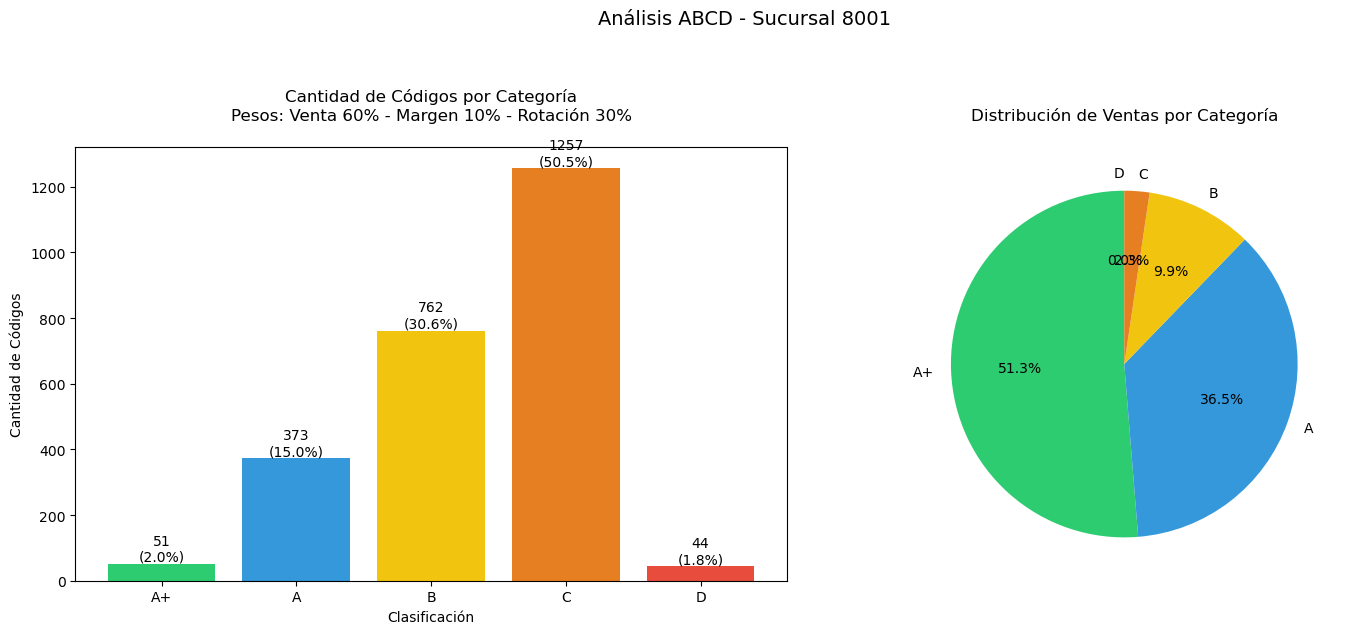


Top 5 Productos A+:
------------------------------------------------------------------------------------------------------------------------
      Cod Mat SAP                          Descripción Mat     Vta $  Margen_Porcentaje  Dias con Venta  Cantidad  Score_Combinado
2080       200051   225/75R16 10PR 115/112Q SL366 GOODRIDE  25971558              51.77              23       221        95.792101
2192       200395    205/75R16C 8PR 110/108Q H188 GOODRIDE  10683859              46.73              34       156        94.636405
2085       200058   245/70R16 10PR 118/115Q SL369 GOODRIDE  26263229              39.31              52       300        94.235412
2188       200391    195/75R16C 8PR 107/105R H188 GOODRIDE   8768902              45.27              29       135        94.018907
2343       200845  295/80R22.5 18PR 152/149K GDM1 GOODRIDE  22449849              52.45              11        80        93.804141

Resultados guardados en 'clasificacion_abc_completa.xlsx'


In [6]:
# Leer el dataset limpio
df_clean = pd.read_excel('sales_last_year_clean.xlsx')

def clasificacion_contribucion_rotacion(df, sucursal=None):
    # Filtrar por sucursal si se especifica
    if sucursal:
        df = df[df['Código Sucursal'] == sucursal]
        
    # Agrupar datos por producto
    producto_metricas = df.groupby(['Cod Mat SAP', 'Descripción Mat', 'Código Sucursal']).agg({
        'Vta $': 'sum',
        'Mg $': 'sum',
        'Cantidad': 'sum',
        'Dias con Venta': 'sum',
        'Ultima Venta': 'max'
    }).reset_index()
    
    # Calcular métricas por sucursal
    producto_metricas['Margen_Porcentaje'] = (producto_metricas['Mg $'] / producto_metricas['Vta $'] * 100).round(2)
    
    # Calcular percentiles para cada métrica dentro de cada sucursal
    producto_metricas['Percentil_Venta'] = producto_metricas.groupby('Código Sucursal')['Vta $'].rank(pct=True) * 100
    producto_metricas['Percentil_Margen'] = producto_metricas.groupby('Código Sucursal')['Margen_Porcentaje'].rank(pct=True) * 100
    producto_metricas['Percentil_Rotacion'] = producto_metricas.groupby('Código Sucursal')['Dias con Venta'].rank(pct=True) * 100
    
    # Calcular score combinado con nuevos pesos
    producto_metricas['Score_Combinado'] = (
        0.60 * producto_metricas['Percentil_Venta'] +     # Venta (60%)
        0.10 * producto_metricas['Percentil_Margen'] +    # Margen (10%)
        0.30 * producto_metricas['Percentil_Rotacion']    # Rotación (30%)
    )
    
    # Asignar clasificación combinada
    def asignar_clasificacion_combinada(score):
        if score >= 90:
            return 'A+'
        elif score >= 75:
            return 'A'
        elif score >= 50:
            return 'B'
        elif score > 0:
            return 'C'
        else:
            return 'D'
    
    producto_metricas['Clasificacion_Combinada'] = producto_metricas['Score_Combinado'].apply(asignar_clasificacion_combinada)
    
    return producto_metricas

# Analizar sucursal 8001
sucursal_analisis = 8001
resultado_sucursal = clasificacion_contribucion_rotacion(df_clean, sucursal_analisis)

# Preparar datos para visualización
resumen = resultado_sucursal.groupby('Clasificacion_Combinada').agg({
    'Cod Mat SAP': 'count',
    'Vta $': 'sum'
}).reset_index()

resumen['Porcentaje_Productos'] = (resumen['Cod Mat SAP'] / len(resultado_sucursal) * 100).round(2)
resumen['Porcentaje_Venta'] = (resumen['Vta $'] / resultado_sucursal['Vta $'].sum() * 100).round(2)

# Ordenar las categorías
orden_categorias = ['A+', 'A', 'B', 'C', 'D']
resumen['Clasificacion_Combinada'] = pd.Categorical(resumen['Clasificacion_Combinada'], 
                                                  categories=orden_categorias, 
                                                  ordered=True)
resumen = resumen.sort_values('Clasificacion_Combinada')

# Crear visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Colores para las categorías
colors = ['#2ecc71', '#3498db', '#f1c40f', '#e67e22', '#e74c3c']

# Gráfico de barras para cantidad de códigos
ax1.bar(resumen['Clasificacion_Combinada'], resumen['Cod Mat SAP'], color=colors)
ax1.set_title('Cantidad de Códigos por Categoría\nPesos: Venta 60% - Margen 10% - Rotación 30%', pad=20)
ax1.set_xlabel('Clasificación')
ax1.set_ylabel('Cantidad de Códigos')

# Añadir etiquetas sobre las barras
for i, v in enumerate(resumen['Cod Mat SAP']):
    ax1.text(i, v, f'{int(v)}\n({resumen["Porcentaje_Productos"].iloc[i]:.1f}%)', 
             ha='center', va='bottom')

# Gráfico de torta para porcentaje de ventas
wedges, texts, autotexts = ax2.pie(resumen['Porcentaje_Venta'], 
                                  labels=resumen['Clasificacion_Combinada'], 
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  startangle=90)
ax2.set_title('Distribución de Ventas por Categoría', pad=20)

plt.suptitle(f'Análisis ABCD - Sucursal {sucursal_analisis}', fontsize=14, y=1.05)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir Top 5 A+ y A
print("\nTop 5 Productos A+:")
print("-" * 120)
top_aplus = resultado_sucursal[
    resultado_sucursal['Clasificacion_Combinada'] == 'A+'
].sort_values('Score_Combinado', ascending=False).head()

print(top_aplus[[
    'Cod Mat SAP', 'Descripción Mat', 
    'Vta $', 'Margen_Porcentaje', 'Dias con Venta',
    'Cantidad', 'Score_Combinado'
]].to_string())

sucursales = df_clean['Código Sucursal'].unique()
resultados_todas_sucursales = pd.DataFrame()

for sucursal in sucursales:
    resultado_sucursal = clasificacion_contribucion_rotacion(df_clean, sucursal)
    resultados_todas_sucursales = pd.concat([resultados_todas_sucursales, resultado_sucursal])

# Guardar resultados en Excel con todas las columnas
resultados_todas_sucursales.to_excel('clasificacion_abc_completa.xlsx', index=False)
print("\nResultados guardados en 'clasificacion_abc_completa.xlsx'")


**Explorar Clasificacion ABCD**

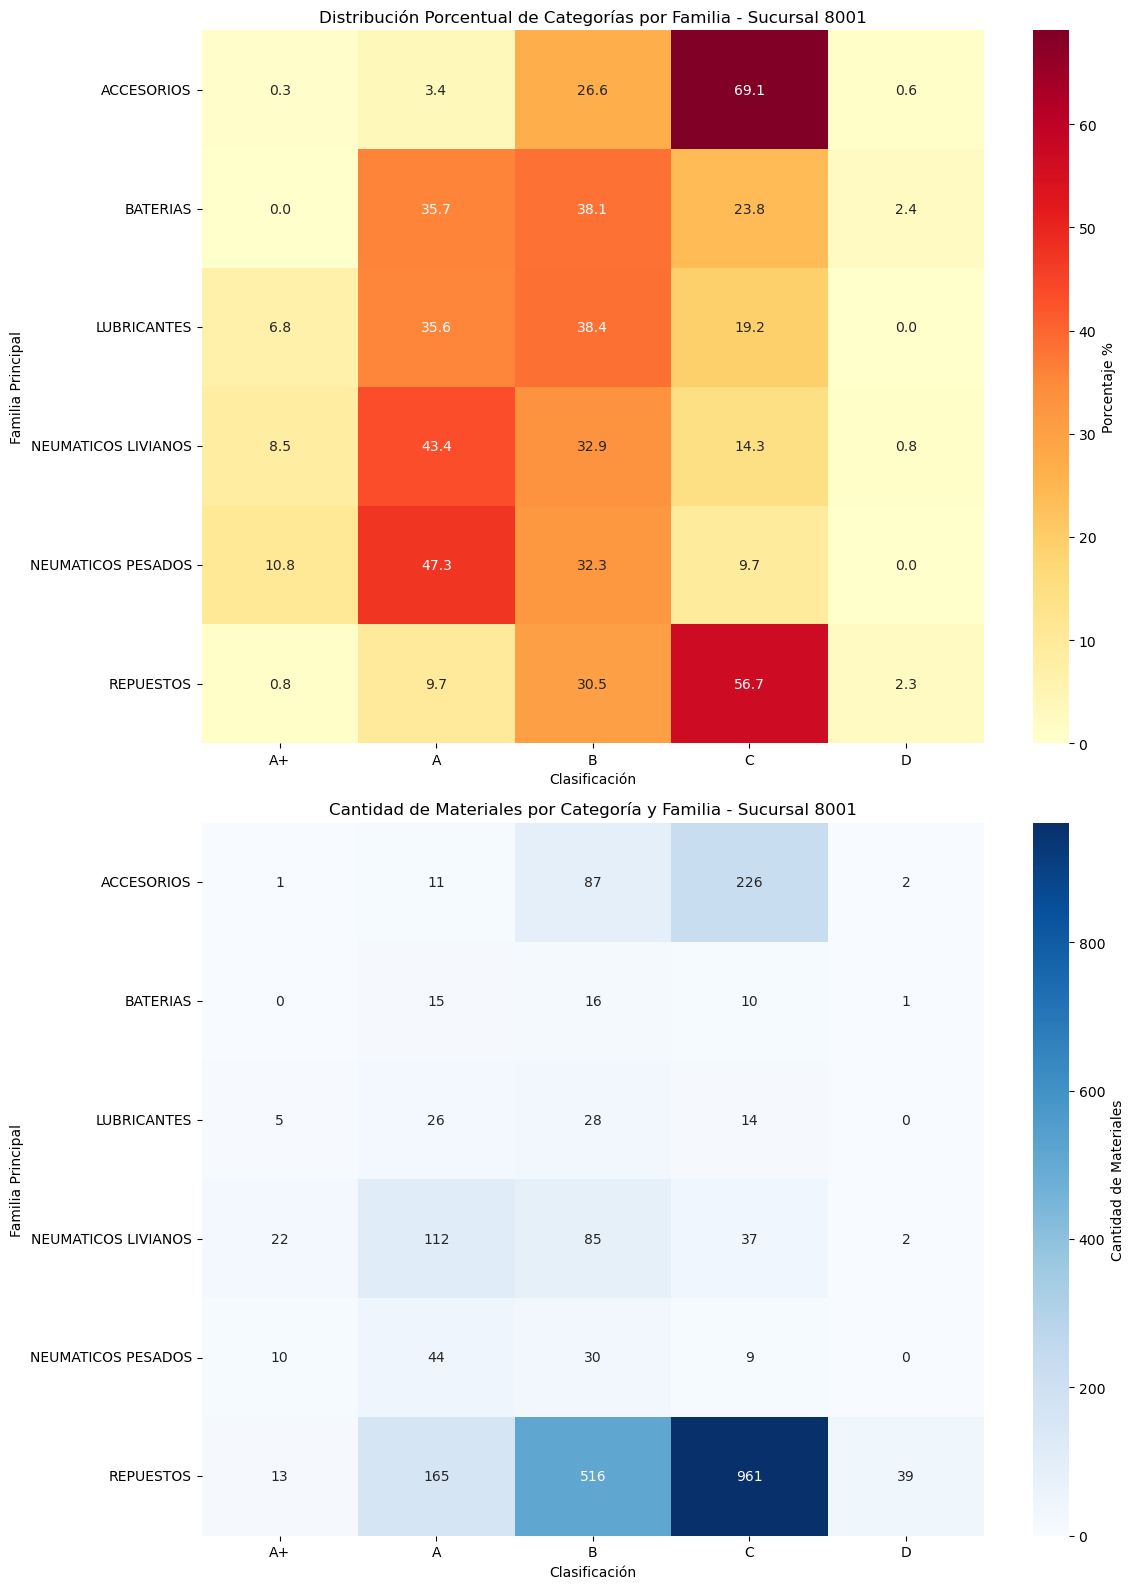

In [ ]:
# Clustering de productos con KMeans
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Segunda celda - Carga y limpieza de datos
# Lectura del archivo
df = pd.read_excel('sales_last_year.xlsx')

# Limpieza básica
df_clean = df.copy()
df_clean = df_clean[df_clean['Vta $'] >= 0]

# Tercera celda - Función de clasificación
def clasificacion_contribucion_rotacion(df, sucursal):
    # Filtrar por sucursal
    df = df[df['Código Sucursal'] == sucursal]
        
    # Agrupar datos por producto
    producto_metricas = df.groupby(['Cod Mat SAP', 'Descripción Mat', 'Familia Principal']).agg({
        'Vta $': 'sum',
        'Mg $': 'sum',
        'Cantidad': 'sum',
        'Dias con Venta': 'sum',
        'Ultima Venta': 'max'
    }).reset_index()
    
    # Calcular métricas
    producto_metricas['Margen_Porcentaje'] = (producto_metricas['Mg $'] / producto_metricas['Vta $'] * 100).round(2)
    
    # Calcular percentiles para cada métrica
    producto_metricas['Percentil_Venta'] = producto_metricas['Vta $'].rank(pct=True) * 100
    producto_metricas['Percentil_Margen'] = producto_metricas['Margen_Porcentaje'].rank(pct=True) * 100
    producto_metricas['Percentil_Rotacion'] = producto_metricas['Dias con Venta'].rank(pct=True) * 100
    
    # Calcular score combinado
    producto_metricas['Score_Combinado'] = (
        0.60 * producto_metricas['Percentil_Venta'] +     # Venta (60%)
        0.10 * producto_metricas['Percentil_Margen'] +    # Margen (10%)
        0.30 * producto_metricas['Percentil_Rotacion']    # Rotación (30%)
    )
    
    # Asignar clasificación combinada
    def asignar_clasificacion_combinada(score):
        if score >= 90:
            return 'A+'
        elif score >= 75:
            return 'A'
        elif score >= 50:
            return 'B'
        elif score > 0:
            return 'C'
        else:
            return 'D'
    
    producto_metricas['Clasificacion_Combinada'] = producto_metricas['Score_Combinado'].apply(asignar_clasificacion_combinada)
    
    return producto_metricas

# Cuarta celda - Procesar sucursal 8001
sucursal_8001 = clasificacion_contribucion_rotacion(df_clean, 8001)

# Quinta celda - Función de visualización
def visualizar_distribucion_familias(df, sucursal):
    # Crear figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # 1. Heatmap de porcentajes
    pivot_pct = pd.crosstab(df['Familia Principal'], 
                           df['Clasificacion_Combinada'], 
                           normalize='index') * 100
    
    orden_categorias = ['A+', 'A', 'B', 'C', 'D']
    pivot_pct = pivot_pct[orden_categorias]
    
    sns.heatmap(pivot_pct, 
                annot=True, 
                fmt='.1f', 
                cmap='YlOrRd',
                ax=ax1,
                cbar_kws={'label': 'Porcentaje %'})
    
    ax1.set_title(f'Distribución Porcentual de Categorías por Familia - Sucursal {sucursal}')
    ax1.set_ylabel('Familia Principal')
    ax1.set_xlabel('Clasificación')
    
    # 2. Heatmap de cantidades
    pivot_cant = pd.crosstab(df['Familia Principal'], 
                            df['Clasificacion_Combinada'])
    
    pivot_cant = pivot_cant[orden_categorias]
    
    sns.heatmap(pivot_cant, 
                annot=True, 
                fmt='g', 
                cmap='Blues',
                ax=ax2,
                cbar_kws={'label': 'Cantidad de Materiales'})
    
    ax2.set_title(f'Cantidad de Materiales por Categoría y Familia - Sucursal {sucursal}')
    ax2.set_ylabel('Familia Principal')
    ax2.set_xlabel('Clasificación')
    
    plt.tight_layout()
    plt.show()

# Sexta celda - Ejecutar visualización
visualizar_distribucion_familias(sucursal_8001, 8001)

# Opcional: Guardar resultados de la sucursal 8001
sucursal_8001.to_excel('clasificacion_abc_sucursal_8001.xlsx', index=False)

**Comparacion Clasificacion ABCD vs Clustering kmeans**

Verificación inicial de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2487 entries, 0 to 2486
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Cod Mat SAP              2487 non-null   int64         
 1   Descripción Mat          2487 non-null   object        
 2   Familia Principal        2487 non-null   object        
 3   Vta $                    2487 non-null   float64       
 4   Mg $                     2487 non-null   float64       
 5   Cantidad                 2487 non-null   float64       
 6   Dias con Venta           2487 non-null   int64         
 7   Ultima Venta             2487 non-null   datetime64[ns]
 8   Margen_Porcentaje        2443 non-null   float64       
 9   Percentil_Venta          2487 non-null   float64       
 10  Percentil_Margen         2443 non-null   float64       
 11  Percentil_Rotacion       2487 non-null   float64       
 12  Sco

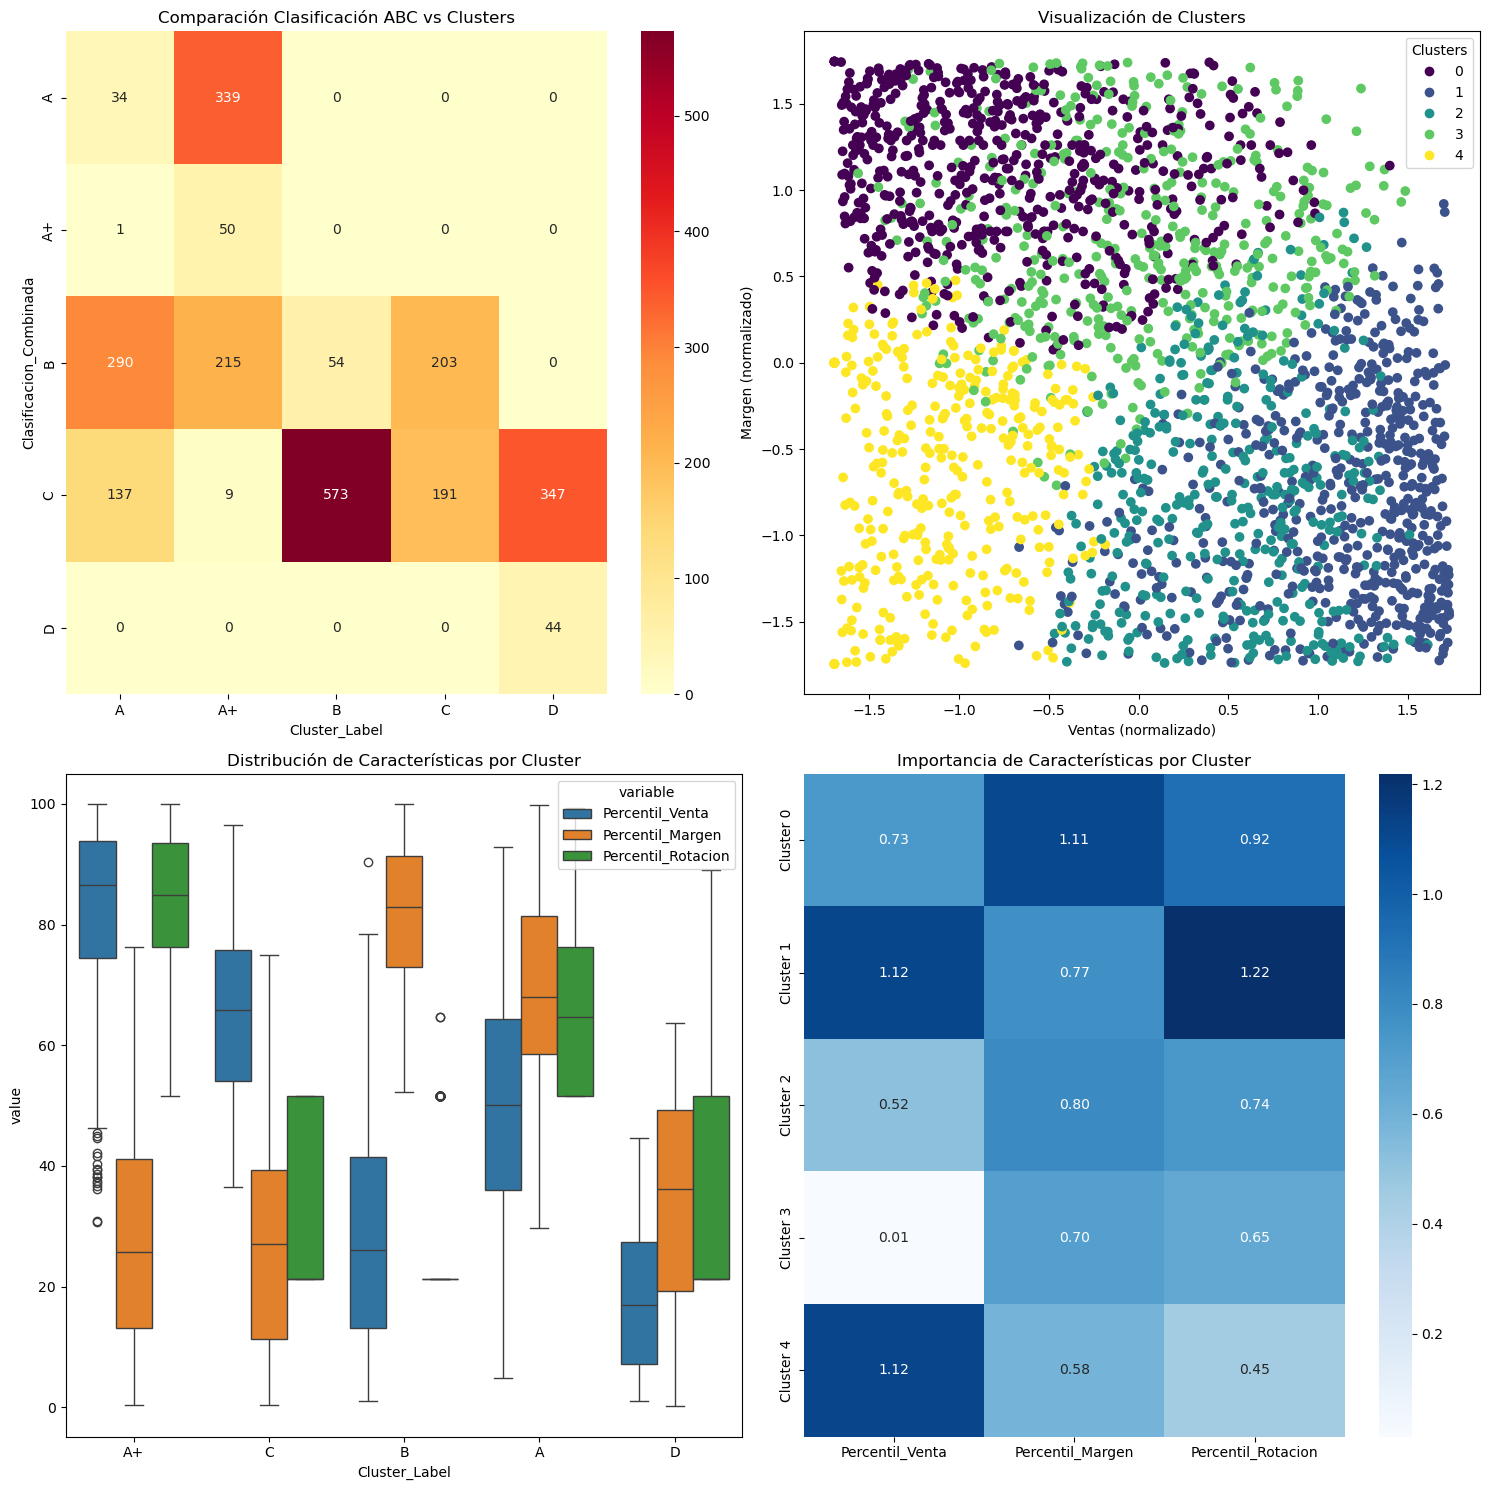


Concordancia entre clasificación ABC y clusters: 15.00%

Resumen de clusters:
               Percentil_Venta  Percentil_Margen  Percentil_Rotacion
Cluster_Label                                                       
A                        50.38             69.98               67.85
A+                       82.34             27.91               83.70
B                        28.89             81.67               24.49
C                        65.04             27.27               29.68
D                        17.67             33.29               37.59


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def aplicar_kmeans(df_sucursal):
    """
    Aplica K-Means al dataset de una sucursal y compara con clasificación ABC
    """
    # Primero verificamos y limpiamos datos nulos
    print("\nVerificación de valores nulos:")
    print(df_sucursal[['Percentil_Venta', 'Percentil_Margen', 'Percentil_Rotacion']].isnull().sum())
    
    # Limpiamos reemplazando NaN con 0 o la media
    df_sucursal = df_sucursal.copy()
    features = ['Percentil_Venta', 'Percentil_Margen', 'Percentil_Rotacion']
    
    for feature in features:
        df_sucursal[feature] = df_sucursal[feature].fillna(df_sucursal[feature].mean())
    
    # Verificamos que no queden nulos
    print("\nValores nulos después de limpieza:")
    print(df_sucursal[features].isnull().sum())
    
    # Seleccionar características para clustering
    X = df_sucursal[features].values
    
    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar K-Means (k=5 para match con A+,A,B,C,D)
    kmeans = KMeans(n_clusters=5, random_state=42)
    df_sucursal['Cluster'] = kmeans.fit_predict(X_scaled)
    
    # Analizar centroides
    centroides = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=features
    )
    
    # Ordenar clusters por valor promedio
    cluster_means = df_sucursal.groupby('Cluster')[features].mean()
    cluster_scores = cluster_means.mean(axis=1)
    cluster_mapping = dict(
        zip(
            cluster_scores.sort_values(ascending=False).index,
            ['A+', 'A', 'B', 'C', 'D']
        )
    )
    
    df_sucursal['Cluster_Label'] = df_sucursal['Cluster'].map(cluster_mapping)
    
    # Visualizaciones
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
    # 1. Comparación de distribuciones
    comparacion = pd.crosstab(
        df_sucursal['Clasificacion_Combinada'],
        df_sucursal['Cluster_Label']
    )
    
    sns.heatmap(comparacion, 
                annot=True, 
                fmt='g',
                cmap='YlOrRd',
                ax=ax1)
    ax1.set_title('Comparación Clasificación ABC vs Clusters')
    
    # 2. Scatter plot de clusters
    scatter = ax2.scatter(
        X_scaled[:, 0],
        X_scaled[:, 1],
        c=df_sucursal['Cluster'],
        cmap='viridis'
    )
    ax2.set_xlabel('Ventas (normalizado)')
    ax2.set_ylabel('Margen (normalizado)')
    ax2.set_title('Visualización de Clusters')
    ax2.legend(*scatter.legend_elements(), title="Clusters")
    
    # 3. Distribución de características por cluster
    df_melted = pd.melt(df_sucursal, 
                        value_vars=features,
                        id_vars=['Cluster_Label'])
    
    sns.boxplot(x='Cluster_Label', 
                y='value',
                hue='variable',
                data=df_melted,
                ax=ax3)
    ax3.set_title('Distribución de Características por Cluster')
    
    # 4. Importancia de características por cluster
    importancia = np.abs(kmeans.cluster_centers_)
    importancia_df = pd.DataFrame(
        importancia,
        columns=features,
        index=['Cluster ' + str(i) for i in range(5)]
    )
    
    sns.heatmap(importancia_df,
                annot=True,
                fmt='.2f',
                cmap='Blues',
                ax=ax4)
    ax4.set_title('Importancia de Características por Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de concordancia
    concordancia = (df_sucursal['Clasificacion_Combinada'] == df_sucursal['Cluster_Label']).mean() * 100
    
    print(f"\nConcordancia entre clasificación ABC y clusters: {concordancia:.2f}%")
    
    # Mostrar resumen de clusters
    print("\nResumen de clusters:")
    print(df_sucursal.groupby('Cluster_Label')[features].mean().round(2))
    
    return df_sucursal, centroides

# Verificar los datos antes de aplicar K-means
print("Verificación inicial de datos:")
print(sucursal_8001.info())

# Aplicar a la sucursal 8001
df_con_clusters, centroides = aplicar_kmeans(sucursal_8001)

# Guardar resultados
df_con_clusters.to_excel('clasificacion_abc_kmeans_8001.xlsx', index=False)

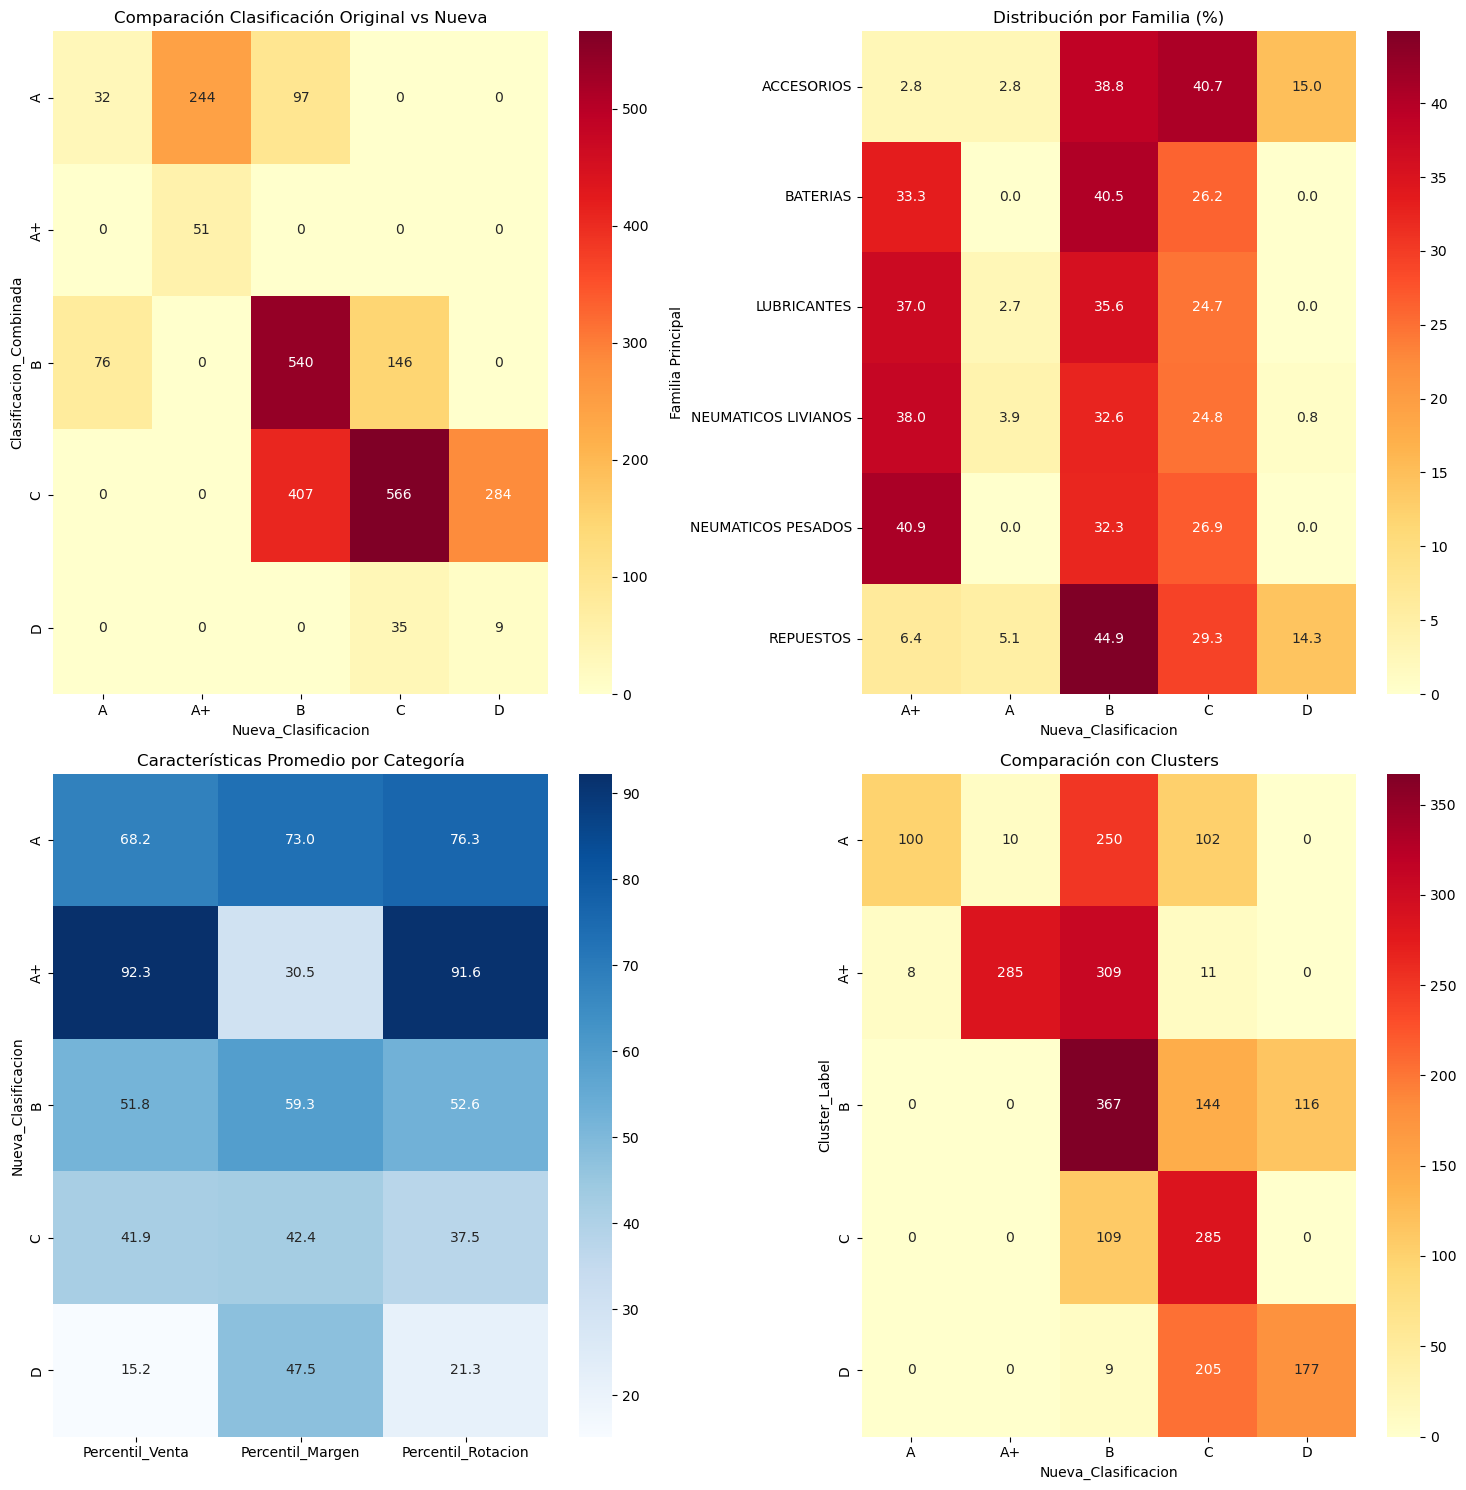


Distribución de nueva clasificación:
A+: 295 productos (11.9%)
A: 108 productos (4.3%)
B: 1044 productos (42.0%)
C: 747 productos (30.0%)
D: 293 productos (11.8%)

Concordancia con clusters: 48.81%


In [9]:
def nueva_clasificacion_abc(df):
    """
    Aplica nueva estrategia de clasificación basada en los resultados de K-means
    
    Args:
        df: DataFrame con las columnas Percentil_Venta, Percentil_Margen, Percentil_Rotacion
    Returns:
        DataFrame con nueva clasificación
    """
    df = df.copy()
    
    # Definir las condiciones para cada categoría
    condiciones = [
        # A+ : Alto en ventas Y rotación
        ((df['Percentil_Venta'] > 80) & (df['Percentil_Rotacion'] > 80)),
        
        # A : Balance en todas las métricas
        ((df['Percentil_Venta'] > 50) & 
         (df['Percentil_Rotacion'] > 60) & 
         (df['Percentil_Margen'] > 60)),
        
        # B : Alto margen O buenos indicadores generales
        ((df['Percentil_Margen'] > 80) | 
         ((df['Percentil_Venta'] > 40) & (df['Percentil_Rotacion'] > 40))),
        
        # C : Ventas o rotación moderadas
        ((df['Percentil_Venta'] > 30) | (df['Percentil_Rotacion'] > 30))
    ]
    
    # Definir las categorías correspondientes
    categorias = ['A+', 'A', 'B', 'C']
    
    # Aplicar clasificación por defecto (D)
    df['Nueva_Clasificacion'] = 'D'
    
    # Aplicar las condiciones en orden
    for condicion, categoria in zip(condiciones, categorias):
        df.loc[condicion & (df['Nueva_Clasificacion'] == 'D'), 'Nueva_Clasificacion'] = categoria
    
    return df

def analizar_nueva_clasificacion(df):
    """
    Analiza y visualiza los resultados de la nueva clasificación
    """
    # Aplicar nueva clasificación
    df_nuevo = nueva_clasificacion_abc(df)
    
    # Crear visualizaciones
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
    # 1. Comparación con clasificación original
    comparacion = pd.crosstab(df_nuevo['Clasificacion_Combinada'], 
                             df_nuevo['Nueva_Clasificacion'])
    
    sns.heatmap(comparacion, 
                annot=True, 
                fmt='g',
                cmap='YlOrRd',
                ax=ax1)
    ax1.set_title('Comparación Clasificación Original vs Nueva')
    
    # 2. Distribución por Familia
    familia_dist = pd.crosstab(df_nuevo['Familia Principal'], 
                              df_nuevo['Nueva_Clasificacion'], 
                              normalize='index') * 100
    
    orden_categorias = ['A+', 'A', 'B', 'C', 'D']
    familia_dist = familia_dist[orden_categorias]
    
    sns.heatmap(familia_dist,
                annot=True,
                fmt='.1f',
                cmap='YlOrRd',
                ax=ax2)
    ax2.set_title('Distribución por Familia (%)')
    
    # 3. Características promedio por nueva categoría
    promedios = df_nuevo.groupby('Nueva_Clasificacion')[
        ['Percentil_Venta', 'Percentil_Margen', 'Percentil_Rotacion']
    ].mean()
    
    sns.heatmap(promedios,
                annot=True,
                fmt='.1f',
                cmap='Blues',
                ax=ax3)
    ax3.set_title('Características Promedio por Categoría')
    
    # 4. Comparación con clusters
    cluster_comp = pd.crosstab(df_nuevo['Cluster_Label'], 
                              df_nuevo['Nueva_Clasificacion'])
    
    sns.heatmap(cluster_comp,
                annot=True,
                fmt='g',
                cmap='YlOrRd',
                ax=ax4)
    ax4.set_title('Comparación con Clusters')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print("\nDistribución de nueva clasificación:")
    nueva_dist = df_nuevo['Nueva_Clasificacion'].value_counts()
    total = len(df_nuevo)
    for cat in orden_categorias:
        count = nueva_dist.get(cat, 0)
        print(f"{cat}: {count} productos ({(count/total*100):.1f}%)")
    
    # Concordancia con clusters
    concordancia = (df_nuevo['Nueva_Clasificacion'] == df_nuevo['Cluster_Label']).mean() * 100
    print(f"\nConcordancia con clusters: {concordancia:.2f}%")
    
    return df_nuevo

# Aplicar el análisis
df_nueva_clasificacion = analizar_nueva_clasificacion(df_con_clusters)

# Guardar resultados
df_nueva_clasificacion.to_excel('nueva_clasificacion_abc.xlsx', index=False)

In [10]:
def generar_reporte_comparativo(df):
    """
    Genera un reporte detallado comparando la clasificación original vs la nueva
    
    Args:
        df: DataFrame con ambas clasificaciones
    """
    # Crear reporte detallado
    reporte = pd.DataFrame()
    
    # Información básica del producto
    columnas_base = ['Cod Mat SAP', 'Descripción Mat', 'Familia Principal']
    columnas_metricas = ['Vta $', 'Mg $', 'Cantidad', 'Dias con Venta',
                        'Percentil_Venta', 'Percentil_Margen', 'Percentil_Rotacion']
    
    reporte = df[columnas_base + columnas_metricas].copy()
    
    # Agregar clasificaciones
    reporte['Clasificacion_Original'] = df['Clasificacion_Combinada']
    reporte['Nueva_Clasificacion'] = df['Nueva_Clasificacion']
    
    # Marcar cambios
    reporte['Cambio_Clasificacion'] = reporte.apply(
        lambda x: 'Sin Cambio' if x['Clasificacion_Original'] == x['Nueva_Clasificacion'] 
        else f"De {x['Clasificacion_Original']} a {x['Nueva_Clasificacion']}", axis=1
    )
    
    # Calcular métricas adicionales
    reporte['Margen_Porcentaje'] = (reporte['Mg $'] / reporte['Vta $'] * 100).round(2)
    
    # Ordenar el reporte
    reporte = reporte.sort_values(by=['Familia Principal', 'Vta $'], ascending=[True, False])
    
    # Generar resumen por familia
    resumen_familia = pd.pivot_table(
        reporte,
        index='Familia Principal',
        columns='Nueva_Clasificacion',
        values='Cod Mat SAP',
        aggfunc='count',
        fill_value=0
    ).reset_index()
    
    # Calcular totales por familia
    resumen_familia['Total'] = resumen_familia.iloc[:, 1:].sum(axis=1)
    for col in resumen_familia.columns[1:-1]:
        resumen_familia[f'%_{col}'] = (resumen_familia[col] / resumen_familia['Total'] * 100).round(2)
    
    # Crear archivo Excel con múltiples hojas
    with pd.ExcelWriter('reporte_comparativo_clasificacion.xlsx', engine='openpyxl') as writer:
        # Hoja 1: Detalle completo
        reporte.to_excel(writer, sheet_name='Detalle_Productos', index=False)
        
        # Hoja 2: Resumen por familia
        resumen_familia.to_excel(writer, sheet_name='Resumen_Familias', index=False)
        
        # Hoja 3: Productos que cambiaron
        cambios = reporte[reporte['Cambio_Clasificacion'] != 'Sin Cambio']
        cambios.to_excel(writer, sheet_name='Productos_Reclasificados', index=False)
        
        # Hoja 4: Métricas por clasificación
        metricas_clase = reporte.groupby('Nueva_Clasificacion').agg({
            'Cod Mat SAP': 'count',
            'Vta $': 'sum',
            'Mg $': 'sum',
            'Cantidad': 'sum',
            'Margen_Porcentaje': 'mean',
            'Percentil_Venta': 'mean',
            'Percentil_Margen': 'mean',
            'Percentil_Rotacion': 'mean'
        }).round(2)
        metricas_clase.to_excel(writer, sheet_name='Metricas_Clasificacion')
    
    # Imprimir resumen
    print("Resumen de cambios:")
    print(reporte['Cambio_Clasificacion'].value_counts())
    print("\nArchivo 'reporte_comparativo_clasificacion.xlsx' generado con éxito")
    
    return reporte

# Generar el reporte
reporte_final = generar_reporte_comparativo(df_nueva_clasificacion)

Resumen de cambios:
Cambio_Clasificacion
Sin Cambio    1198
De C a B       407
De C a D       284
De A a A+      244
De B a C       146
De A a B        97
De B a A        76
De D a C        35
Name: count, dtype: int64

Archivo 'reporte_comparativo_clasificacion.xlsx' generado con éxito


**Scikit-fuzzy**

In [11]:
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.


In [18]:
def crear_sistema_fuzzy():
    # Definir variables fuzzy
    venta = ctrl.Antecedent(np.arange(0, 101, 1), 'venta')
    rotacion = ctrl.Antecedent(np.arange(0, 101, 1), 'rotacion')
    margen = ctrl.Antecedent(np.arange(0, 101, 1), 'margen')
    clasificacion = ctrl.Consequent(np.arange(0, 101, 1), 'clasificacion')

    # Definir funciones de membresía
    venta['low'] = fuzz.trimf(venta.universe, [0, 0, 50])
    venta['average'] = fuzz.trimf(venta.universe, [25, 50, 75])
    venta['high'] = fuzz.trimf(venta.universe, [50, 100, 100])

    rotacion['low'] = fuzz.trimf(rotacion.universe, [0, 0, 50])
    rotacion['average'] = fuzz.trimf(rotacion.universe, [25, 50, 75])
    rotacion['high'] = fuzz.trimf(rotacion.universe, [50, 100, 100])

    margen['low'] = fuzz.trimf(margen.universe, [0, 0, 50])
    margen['average'] = fuzz.trimf(margen.universe, [25, 50, 75])
    margen['high'] = fuzz.trimf(margen.universe, [50, 100, 100])

    clasificacion['A+'] = fuzz.trimf(clasificacion.universe, [85, 100, 100])
    clasificacion['A'] = fuzz.trimf(clasificacion.universe, [70, 85, 100])
    clasificacion['B'] = fuzz.trimf(clasificacion.universe, [50, 70, 85])

    # Reglas fuzzy
    regla1 = ctrl.Rule(venta['high'] & rotacion['high'] & margen['high'], clasificacion['A+'])
    regla2 = ctrl.Rule(venta['high'] & rotacion['average'], clasificacion['A'])
    regla3 = ctrl.Rule(venta['average'] & rotacion['average'], clasificacion['B'])

    # Sistema de control
    sistema_ctrl = ctrl.ControlSystem([regla1, regla2, regla3])
    sistema = ctrl.ControlSystemSimulation(sistema_ctrl)

    return sistema, venta, rotacion, margen, clasificacion

